# Flight Distance Analysis with Python

## Installing Python libraries
The Flight Distances project uses several Python libraries to manipulate, analyse, and visualise data. Pandas and NumPy are used for data manipulation and analysis while Folium is used for visualising geospatial data with a MarkerCluster plugin, which is responsible for clustering markers on map. Seaborn has been imported in order to prepare more complex data visualisations. Together, these libraries provide a powerful toolkit for working with large datasets, analyzing and visualising geospatial data, and communicating insights from the project.

In [1]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
from folium.plugins import MarkerCluster

# Reading the CSV file into a Pandas dataframe
df = pd.read_csv('FlightDistanceTest.csv')

## Data preprocessing
This step includes familiarisation with the dataset, checking for the NULL values and analysis of the longitude and latitude values. This helps to ensure the accuracy and reliability of subsequent analyses and helps to identify potential issues with the data.

In [2]:
df.head()

,Normalised City Pair,Departure Code,Arrival Code,Departure_lat,Departure_lon,Arrival_lat,Arrival_lon
0,"London, United Kingdom - New York, United Stat...",LHR,JFK,51.5,-0.45,40.64,-73.79
1,"Johannesburg, South Africa - London, United Ki...",JNB,LHR,-26.1,28.23,51.47,-0.45
2,"London, United Kingdom - New York, United Stat...",LHR,JFK,51.5,-0.45,40.64,-73.79
3,"Johannesburg, South Africa - London, United Ki...",JNB,LHR,-26.1,28.23,51.47,-0.45
4,"London, United Kingdom - Singapore, Singapore",SIN,LHR,1.3,103.98,51.47,-0.45


In [3]:
df.shape

(3000, 7)

The dataset consists of flight routes with their corresponding departure and arrival airports' codes, latitude and longitude coordinates, and the calculated point-to-point distances between them. The data is stored in a CSV file and includes 7 columns: "Normalised City Pair", "Departure Code", "Arrival Code", "Departure_lat", "Departure_lon", "Arrival_lat" and "Arrival_lon", as well as 3000 entries.

### NULL values

In [4]:
# Counting the number of NULL values in each column
df.isnull().sum()

Normalised City Pair    0
Departure Code          0
Arrival Code            0
Departure_lat           0
Departure_lon           0
Arrival_lat             0
Arrival_lon             0
dtype: int64

Luckily, the dataset does not contain any missing values, which means that there is no need to perform any imputation or deletion of rows or columns with missing data. This ensures that the analysis of this dataset will not be compromised by the absence of any crucial information.

### Wrong values

In [5]:
# The check_coordinates function, that works out whether the longitude and latitude values are withing possible ranges
def check_coordinates(df):
    invalid_rows = 0

    for index, row in df.iterrows():
        if row['Departure_lat'] < -90 or row['Departure_lat'] > 90: # Each latitude value has to fall into [-90; 90] range
            invalid_rows += 1
        elif row['Arrival_lat'] < -90 or row['Arrival_lat'] > 90:
            invalid_rows += 1
        elif row['Departure_lon'] < -180 or row['Departure_lon'] > 180: # Each longitude value has to fall into [-180; 180] range
            invalid_rows += 1
        elif row['Arrival_lon'] < -180 or row['Arrival_lon'] > 180:
            invalid_rows += 1

    print(f"Number of invalid rows: {invalid_rows}")

In [6]:
check_coordinates(df)

Number of invalid rows: 0


Based on the outcome, there do not appear to be any longitude and latitude values that are outside the expected range. This suggests that the latitude and longitude values provided in the dataset are valid and fall within the standard range of values for their respective geographic coordinates.

## Calculating distance between the airports
To determine the distance between two airports, it is necessary to use the haversine formula. This formula is used to calculate the great-circle distance between two points on a sphere, such as the Earth. The haversine formula takes into account the latitude and longitude coordinates of each airport to determine the shortest distance between them. It is based on the assumption that the Earth is a perfect sphere, which is not entirely accurate, but is generally acceptable for most applications.

In [15]:
# The haversine function to calculate the great circle distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    r = 6371  # Earth's avg radius in km

    # Convert latitudes and longitudes from decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the differences between the latitudes and longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate the distance using the haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = r * c

    return distance

In [16]:
df['Distance_km'] = haversine(df['Departure_lat'], df['Departure_lon'], df['Arrival_lat'], df['Arrival_lon'])
df.head()

,Normalised City Pair,Departure Code,Arrival Code,Departure_lat,Departure_lon,Arrival_lat,Arrival_lon,Distance_km
0,"London, United Kingdom - New York, United Stat...",LHR,JFK,51.5,-0.45,40.64,-73.79,5540.141604
1,"Johannesburg, South Africa - London, United Ki...",JNB,LHR,-26.1,28.23,51.47,-0.45,9070.076116
2,"London, United Kingdom - New York, United Stat...",LHR,JFK,51.5,-0.45,40.64,-73.79,5540.141604
3,"Johannesburg, South Africa - London, United Ki...",JNB,LHR,-26.1,28.23,51.47,-0.45,9070.076116
4,"London, United Kingdom - Singapore, Singapore",SIN,LHR,1.3,103.98,51.47,-0.45,10885.973529


The script computed the distance between the departure and arrival airports using the Haversine formula and added it as a new column named 'Distance_km' to the original dataframe. Upon inspection, the results appear to be logical and consistent with the actual distance values obtained from external sources on the internet.


|ID|Script's result in km| Data from Internet in km |
|---|---|--------------------------|
|0|5540.14| 5539.65                  |
|1|9070.08| 9074.78                  |
|4|10885.97| 10883.30                 |

## Data visualisations

### Visualisation of the distribution of the 'Distance_km' column using a histogram

[Text(0.5, 1.0, 'Distribution of Point-to-Point Distances')]

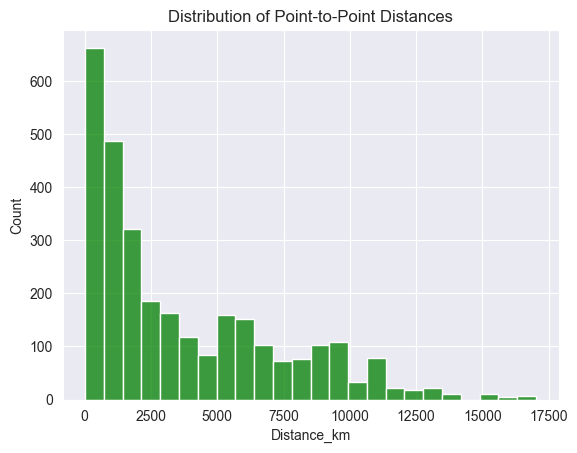

In [9]:
sns.histplot(df, x='Distance_km', color='green').set(title='Distribution of Point-to-Point Distances')

### Map of departure airports and number of flights from each place.

In [12]:
# Group the data by departure airport and count the number of entries from each airport
airport_counts = df.groupby(['Departure_lat', 'Departure_lon']).size().reset_index(name='Counts')

# Define the center of the map as the average latitude and longitude of all airports in the dataframe
map_center = [df[['Departure_lat', 'Departure_lon', 'Arrival_lat', 'Arrival_lon']].mean().values[0],
              df[['Departure_lat', 'Departure_lon', 'Arrival_lat', 'Arrival_lon']].mean().values[1]]

# Create a Folium map centered at the average latitude and longitude of all airports in the dataframe
m = folium.Map(location=map_center, zoom_start=2)

# Create a marker cluster for the departure airports
mc = MarkerCluster()

# Add a marker for each departure airport, with the size of the marker corresponding to the number of entries from that airport
for index, row in airport_counts.iterrows():
    label = f"Number of flights from this airport: {row['Counts']}"
    mc.add_child(folium.CircleMarker(location=(row['Departure_lat'], row['Departure_lon']),
                                     radius=row['Counts']/5,
                                     color='blue', fill=True, fill_opacity=0.4,
                                     tooltip=label))

# Add the marker cluster to the map
m.add_child(mc)

# Display the map
m